# Fabrication Sensitivity Analysis: Is Our Design Robust?

> The adjoint-optimized grating from the previous notebook delivers excellent nominal performance. In practice, however, fabrication variability means the manufactured device rarely matches the design exactly. Here we quantify how the current design responds to some assumed process deviations to see whether it is robust or brittle.

> In the adjoint notebook we purposefully focused on maximizing performance at the nominal geometry. The natural follow-up question is: *how does that optimized design behave once it leaves the computer?* Photonic fabrication processes inevitably introduce small deviations in etched dimensions. Even a well-controlled foundry run can exhibit ±20 nm variations in tooth widths and gaps due to lithography or etch bias. A design that is overly sensitive to these changes might look great in simulation yet fail to meet targets on wafer, so our immediate goal is to measure that sensitivity before pursuing robustness improvements.

## Modeling Fabrication Errors with a Bias

We begin by reloading the best adjoint design and defining a simple bias model. A ±20 nm shift in feature dimensions is a realistic foundry tolerance, so we will simulate three cases: the nominal geometry, an over-etched device (features narrower than intended), and an under-etched device (features wider than intended). This gives an intuitive first look at the design's sensitivity before launching a full Monte Carlo analysis.

In [ ]:
import json
from pathlib import Path

import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tidy3d as td
from autograd import value_and_grad
from scipy.stats import norm
from setup import (
    center_wavelength,
    default_spacer_thickness,
    get_mode_monitor_power,
    make_simulation,
)
from tidy3d import web

In [2]:
def load_nominal_parameters(path):
    """Load a design JSON (Bayes or adjoint) into numpy-friendly fields."""
    data = json.loads(Path(path).read_text(encoding="utf-8"))
    return {
        "widths_si": np.array(data["widths_si"]),
        "gaps_si": np.array(data["gaps_si"]),
        "widths_sin": np.array(data["widths_sin"]),
        "gaps_sin": np.array(data["gaps_sin"]),
        "first_gap_si": data["first_gap_si"],
        "first_gap_sin": data["first_gap_sin"],
        "spacer_thickness": default_spacer_thickness,
    }

In [3]:
def make_variation_builder(nominal):
    """Return a closure that maps process deltas to a tidy3d Simulation."""
    base_widths_si = np.array(nominal["widths_si"])
    base_gaps_si = np.array(nominal["gaps_si"])

    def builder(overlay_delta=0.0, spacer_delta=0.0, etch_bias=0.0):
        # Etch bias widens features when positive and narrows them when
        # negative, so widths grow with the bias while gaps shrink, mirroring
        # the fabrication effect of over/under etching.
        pert_widths_si = base_widths_si + etch_bias
        pert_gaps_si = base_gaps_si - etch_bias

        return make_simulation(
            pert_widths_si,
            pert_gaps_si,
            nominal["widths_sin"],
            nominal["gaps_sin"],
            first_gap_si=nominal["first_gap_si"] + overlay_delta,
            first_gap_sin=nominal["first_gap_sin"],
            spacer_thickness=nominal["spacer_thickness"] + spacer_delta,
        )

    return builder

In [4]:
design_path = Path("./results") / "gc_adjoint_best.json"

# Load the best apodized design from the previous notebook.
# This will be our nominal, or central, design point for the analysis.
nominal = load_nominal_parameters(design_path)
builder = make_variation_builder(nominal)

# Define the fabrication bias in microns (20 nm).
bias = 0.02

# Create simulations for each fabrication scenario: over-etched, nominal,
# and under-etched. Positive bias widens features, while a negative bias
# corresponds to over-etching that narrows them.
bias_cases = {
    "Over-etched (-20 nm)": builder(etch_bias=-bias),
    "Nominal": builder(),
    "Under-etched (+20 nm)": builder(etch_bias=bias),
}

In [5]:
bias_data = web.run_async(bias_cases, verbose=False)

bias_wavelengths = None
bias_spectra = {}

for label, sim_data in bias_data.items():
    power_da = get_mode_monitor_power(sim_data)
    freqs = power_da.coords["f"].values
    wavelengths = td.C_0 / freqs
    power = np.asarray(power_da.data).squeeze()
    order = np.argsort(wavelengths)
    wavelengths = wavelengths[order]
    power = power[order]

    if bias_wavelengths is None:
        bias_wavelengths = wavelengths

    bias_spectra[label] = power

## Interpreting the Sensitivity Plot

The curves below compare the nominal spectrum to ±20 nm biased geometries. The separation between them conveys how quickly our high-efficiency design degrades under realistic fabrication shifts in tooth width and gap. Watch for both a drop in peak efficiency and a shift of the optimal wavelength.

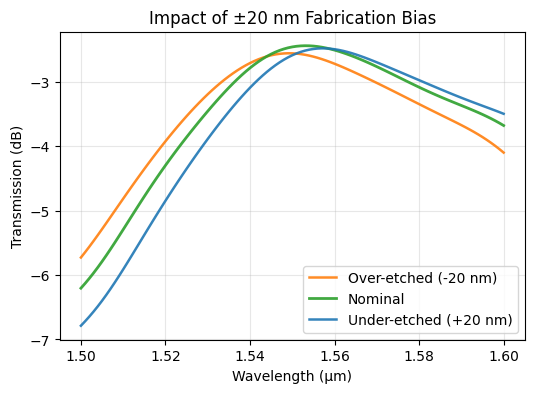

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
colors = {
    "Over-etched (-20 nm)": "tab:orange",
    "Nominal": "tab:green",
    "Under-etched (+20 nm)": "tab:blue",
}

for label, spectrum in bias_spectra.items():
    ax.plot(
        bias_wavelengths,
        10 * np.log10(spectrum),
        label=label,
        color=colors.get(label, None),
        linewidth=2 if label == "Nominal" else 1.8,
        alpha=0.9,
    )

ax.set_xlabel("Wavelength (µm)")
ax.set_ylabel("Transmission (dB)")
ax.set_title("Impact of ±20 nm Fabrication Bias")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [7]:
sigma_spec = {
    "overlay": 0.025,
    "spacer": 0.02,
    "widths_si": 0.01,
}

## Monte Carlo

After inspecting the deterministic bias sweep, we broaden the analysis with a Monte Carlo study. We randomly sample overlay, spacer, and width variations according to foundry-provided sigma values to estimate the distribution of coupling efficiency across a wafer.

In [8]:
seed = 42
num_mc_samples = 100
design_path = Path("./results") / "gc_adjoint_best.json"

In [9]:
nominal = load_nominal_parameters(design_path)
builder = make_variation_builder(nominal)

sigma_vector = np.array([sigma_spec["overlay"], sigma_spec["spacer"], sigma_spec["widths_si"]])
rng = np.random.default_rng(seed)
samples = rng.standard_normal(size=(num_mc_samples, len(sigma_vector))) * sigma_vector

We draw overlay, spacer, and silicon-width perturbations from independent Gaussian models whose sigmas come straight from the (hypothetical) foundry tolerance table. Each row in the `samples` array represents one die that we will feed into the simulation pipeline.

In [10]:
sims = {"nominal": builder()}
sims.update({f"sample_{idx + 1}": builder(*tuple(sample)) for idx, sample in enumerate(samples)})

The closure returned by `make_variation_builder` maps each sampled triplet into a full tidy3d `Simulation`. We keep the nominal design in the dictionary so the subsequent analysis can always reference the baseline spectrum.

In [11]:
batch_data = web.run_async(sims, verbose=False)

We submit the entire batch with `web.run_async` so Tidy3D executes the jobs in parallel since they are all independent.

In [12]:
ordered_names = list(sims.keys())
wavelengths = None
linear_spectra = []

for name in ordered_names:
    sim_data = batch_data[name]
    power_da = get_mode_monitor_power(sim_data)
    freqs = power_da.coords["f"].values
    wl = td.C_0 / freqs
    power = np.asarray(power_da.data).squeeze()
    order = np.argsort(wl)
    wl = wl[order]
    power = power[order]

    if wavelengths is None:
        wavelengths = wl

    linear_spectra.append(power)

linear_array = np.vstack(linear_spectra)
nominal_index = ordered_names.index("nominal")
nominal_spectrum = linear_array[nominal_index]

Once the solver responses return, we stack them into a 2D array and compute statistics such as the mean trace, percentile envelope, and nominal curve for direct comparison.

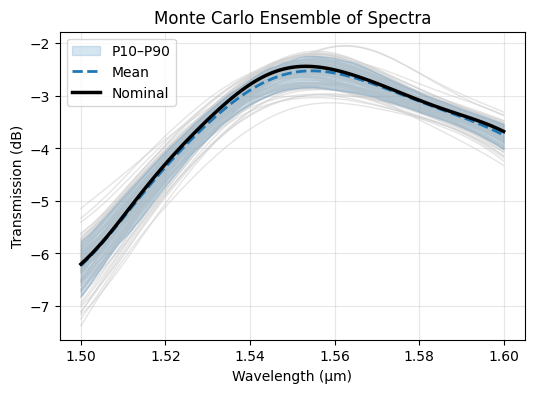

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

for name, spectrum in zip(ordered_names, linear_array):
    if name == "nominal":
        continue
    spectrum_db = 10 * np.log10(spectrum)
    ax.plot(
        wavelengths,
        spectrum_db,
        color="lightgray",
        alpha=0.6,
        linewidth=1,
        zorder=1,
    )

mean_spectrum = linear_array.mean(axis=0)
p10_spectrum = np.percentile(linear_array, 10, axis=0)
p90_spectrum = np.percentile(linear_array, 90, axis=0)

ax.fill_between(
    wavelengths,
    10 * np.log10(p10_spectrum),
    10 * np.log10(p90_spectrum),
    color="tab:blue",
    alpha=0.18,
    label="P10–P90",
    zorder=2,
)
ax.plot(
    wavelengths,
    10 * np.log10(mean_spectrum),
    color="tab:blue",
    linewidth=2,
    linestyle="--",
    label="Mean",
    zorder=3,
)
ax.plot(
    wavelengths,
    10 * np.log10(nominal_spectrum),
    color="black",
    linewidth=2.5,
    label="Nominal",
    zorder=4,
)

ax.set_xlabel("Wavelength (µm)")
ax.set_ylabel("Transmission (dB)")
ax.set_title("Monte Carlo Ensemble of Spectra")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [14]:
def linear_to_loss_db(x):
    return -10 * np.log10(x)


idx_center = np.argmin(np.abs(wavelengths - center_wavelength))
eta_center = linear_array[:, idx_center]

mc_summary = {
    "wavelength_um": wavelengths[idx_center],
    "mean_linear": eta_center.mean(),
    "mean_db": linear_to_loss_db(eta_center.mean()),
    "std_linear": eta_center.std(ddof=1),
    "std_db": linear_to_loss_db(eta_center.mean() - eta_center.std(ddof=1))
    - linear_to_loss_db(eta_center.mean()),
    "p10_linear": np.percentile(eta_center, 10),
    "p10_db": linear_to_loss_db(np.percentile(eta_center, 10)),
    "p90_linear": np.percentile(eta_center, 90),
    "p90_db": linear_to_loss_db(np.percentile(eta_center, 90)),
    "sigma_overlay": sigma_spec["overlay"],
    "sigma_spacer": sigma_spec["spacer"],
    "sigma_widths_si": sigma_spec["widths_si"],
}

pd.Series(mc_summary).to_frame("value")

value
wavelength_um    1.550000
mean_linear      0.554907
mean_db          2.557796
std_linear       0.027393
std_db           0.219866
p10_linear       0.517121
p10_db           2.864077
p90_linear       0.587606
p90_db           2.309138
sigma_overlay    0.025000
sigma_spacer     0.020000
sigma_widths_si  0.010000

The helper converts the center-wavelength transmission into dB loss and aggregates mean, standard deviation, and percentile values. These single-number metrics offer a quick dashboard before moving on to more detailed adjoint sensitivities.

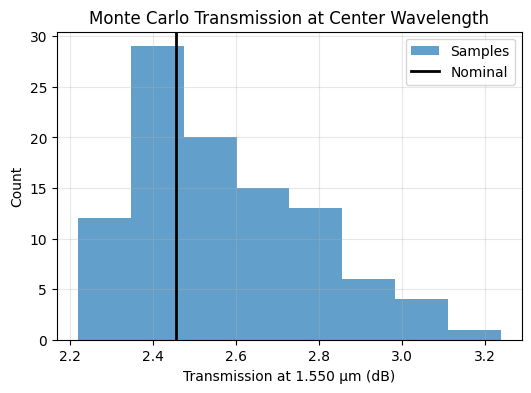

In [15]:
eta_center_db = linear_to_loss_db(eta_center)
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(eta_center_db[1:], bins="auto", color="tab:blue", alpha=0.7, label="Samples")
ax.axvline(eta_center_db[0], color="black", linewidth=2, label="Nominal")
ax.set_xlabel(f"Transmission at {wavelengths[idx_center]:.3f} µm (dB)")
ax.set_ylabel("Count")
ax.set_title("Monte Carlo Transmission at Center Wavelength")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

## Adjoint

### Linearized Sensitivity via Adjoint

Before launching a full robust optimization we want directional information: which fabrication knobs most strongly impact coupling efficiency near the nominal point? The objective below evaluates a single perturbed simulation and, through `value_and_grad`, returns both the power and its gradient with respect to the overlay, spacer, and silicon-width errors.

In [16]:
nominal = load_nominal_parameters(design_path)

In [17]:
def objective(params):
    overlay_delta, spacer_delta, etch_bias = params
    sim = make_simulation(
        nominal["widths_si"] + etch_bias,
        nominal["gaps_si"] - etch_bias,
        nominal["widths_sin"],
        nominal["gaps_sin"],
        first_gap_si=nominal["first_gap_si"] + overlay_delta,
        first_gap_sin=nominal["first_gap_sin"],
        spacer_thickness=nominal["spacer_thickness"] + spacer_delta,
    )
    sim_data = web.run(sim, task_name="gc_sensitivity_adj", verbose=False)
    power_da = get_mode_monitor_power(sim_data)
    target_power = power_da.sel(f=td.C_0 / center_wavelength, method="nearest")
    return target_power.item()

In [18]:
params0 = np.zeros(3)
value, grad = value_and_grad(objective)(params0)

In [19]:
ordered = ("overlay", "spacer", "widths_si")

grads = dict(zip(ordered, grad))
sigmas = {k: float(sigma_spec[k]) for k in ordered}

grad_vec = np.fromiter((grads[k] for k in ordered), dtype=float)
sigma_vec = np.fromiter((sigmas[k] for k in ordered), dtype=float)

# Linearized error propagation
scaled = grad_vec * sigma_vec
variance = scaled @ scaled
std = float(np.sqrt(variance))

# 10th/90th percentiles for Gaussian assumption
z = 1.28155
p10 = value - z * std
p90 = value + z * std

# Normalized variance contribution per parameter
if variance == 0.0:
    importance_dict = dict.fromkeys(ordered, 0.0)
else:
    importance_dict = {k: (s**2) / variance for k, s in zip(ordered, scaled)}

adj_summary = {
    "mean_linear": value,
    "std_linear": std,
    "p10_linear": p10,
    "p90_linear": p90,
    "mean_db": linear_to_loss_db(value),
    "p10_db": linear_to_loss_db(p10),
    "p90_db": linear_to_loss_db(p90),
    "importance": importance_dict,
}

result = {
    "center_wavelength_um": center_wavelength,
    "sigmas": sigmas,
    "gradients_linear": grads,
    "summary": adj_summary,
}

adjoint_stats = pd.Series(
    {
        k: adj_summary[k]
        for k in (
            "mean_linear",
            "std_linear",
            "p10_linear",
            "p90_linear",
            "mean_db",
            "p10_db",
            "p90_db",
        )
    },
    name="adjoint",
)
adjoint_stats.to_frame().style.format("{:.4f}")

In [20]:
importance_ser = pd.Series(adj_summary["importance"], name="importance")
display(importance_ser.to_frame().style.format("{:.3%}"))

### Interpreting Variance Contributions

Normalizing the gradient-scaled sigmas reveals how much each parameter contributes to the linearized variance. Plotting the breakdown highlights the dominant sensitivities we should target when we redesign for robustness.

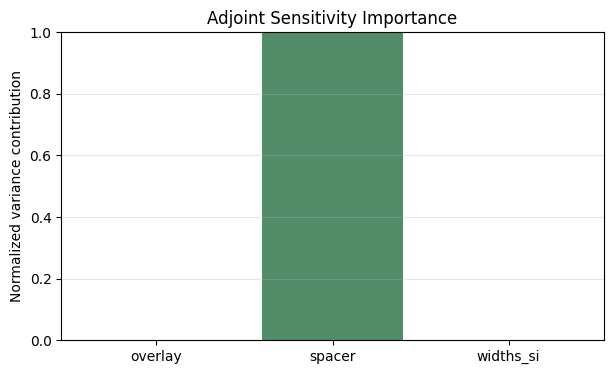

In [21]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(importance_ser.index, importance_ser.values, alpha=0.75)
ax.set_ylim(0, 1)
ax.set_ylabel("Normalized variance contribution")
ax.set_title("Adjoint Sensitivity Importance")
ax.grid(axis="y", alpha=0.3)
plt.show()

## Comparison

### Monte Carlo vs. Adjoint View

Finally we line up the Monte Carlo results with the adjoint prediction. Agreement between the two lenses justifies replacing expensive sampling with cheaper gradient estimates in the next notebook, while any mismatch would signal nonlinearity that the linearized model misses.

In [22]:
comparison = pd.DataFrame(
    {
        "Monte Carlo": {
            "mean_linear": mc_summary["mean_linear"],
            "std_linear": mc_summary["std_linear"],
            "p10_linear": mc_summary["p10_linear"],
            "p90_linear": mc_summary["p90_linear"],
            "mean_db": mc_summary["mean_db"],
            "p10_db": mc_summary["p10_db"],
            "p90_db": mc_summary["p90_db"],
        },
        "Adjoint": {
            "mean_linear": adj_summary["mean_linear"],
            "std_linear": adj_summary["std_linear"],
            "p10_linear": adj_summary["p10_linear"],
            "p90_linear": adj_summary["p90_linear"],
            "mean_db": adj_summary["mean_db"],
            "p10_db": adj_summary["p10_db"],
            "p90_db": adj_summary["p90_db"],
        },
    }
).T

comparison.style.format("{:.4f}")

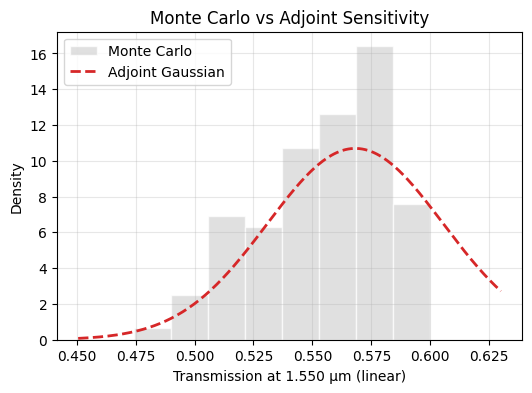

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(
    eta_center,
    bins="auto",
    color="lightgray",
    edgecolor="white",
    alpha=0.7,
    density=True,
    label="Monte Carlo",
)

x = np.linspace(eta_center.min() * 0.95, eta_center.max() * 1.05, 300)
pdf = norm.pdf(x, loc=adj_summary["mean_linear"], scale=adj_summary["std_linear"])
ax.plot(x, pdf, color="tab:red", linewidth=2, linestyle="--", label="Adjoint Gaussian")

ax.set_xlabel(f"Transmission at {center_wavelength:.3f} µm (linear)")
ax.set_ylabel("Density")
ax.set_title("Monte Carlo vs Adjoint Sensitivity")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

## Analysis and Conclusion

The ±20 nm sweep already hinted that the design is somewhat brittle: the peak efficiency drops by roughly a dB and the optimal wavelength shifts under bias. The Monte Carlo and adjoint statistics confirm that fabrication variability will erode performance across a wafer. To address this we need to optimize directly for robustness.

## Next Step: Designing for Robustness

In the next notebook we will incorporate the process variations into the objective function itself, searching for geometries that maintain high efficiency across the biased scenarios rather than just at the nominal point.